In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

import tensorflow as tf

os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

from tensorflow.keras.layers import Input, BatchNormalization, Conv2D
from tensorflow.keras.models import Model

from layers import SparseConv2D

In [2]:
input_shape = (32, 32, 3)
input_sparsity = 0.9
binary = False

mask_shape = list(input_shape[:-1]) + [1]

input_images = np.asarray([np.random.random(input_shape)])
#input_images = np.asarray([np.ones(input_shape)*0.5])
input_masks = np.asarray([np.random.binomial(1, 1-input_sparsity, size=mask_shape)])

if True: # without mask
    input_images *= np.repeat(input_masks, input_images.shape[-1], axis=-1)
    
    inputs = x = Input(shape=input_shape)
    x = SparseConv2D(16, 3, padding='same', binary=binary)(x)
    x = SparseConv2D(32, 3, padding='valid', binary=binary)(x)
    model = Model(inputs, x)

    output_features, output_masks = model.predict(input_images)
else:
    inputs = x = [Input(shape=input_shape), Input(shape=mask_shape)]
    x = SparseConv2D(16, 3, padding='same', binary=binary)(x)
    x = SparseConv2D(32, 3, padding='valid', binary=binary)(x)
    model = Model(inputs, x)

    output_features, output_masks = model.predict([input_images, input_masks])
                          
print(np.count_nonzero(input_images))

print('input_shapes    %s %s' % (input_images.shape, input_masks.shape))
print('output_shapes   %s %s' % (output_features.shape, output_masks.shape))
print('input_sparsity  %.4f' % (input_sparsity))
print('output_sparsity %.4f' % (1-np.count_nonzero(output_masks)/np.prod(output_masks.shape)))

Instructions for updating:
Please use `layer.add_weight` method instead.
225
input_shapes    (1, 32, 32, 3) (1, 32, 32, 1)
output_shapes   (1, 30, 30, 32) (1, 30, 30, 1)
input_sparsity  0.9000
output_sparsity 0.1544


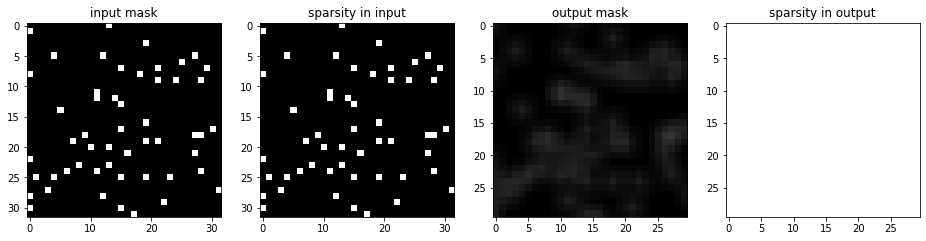

In [3]:
input_sparsity = 0.95
binary = False

input_images = np.asarray([np.random.random(input_shape)])
input_masks = np.asarray([np.random.binomial(1, 1-input_sparsity, size=mask_shape)])
input_images *= np.repeat(input_masks, input_images.shape[-1], axis=-1)

inputs = x = Input(shape=input_shape)
x, m = SparseConv2D(16, 3, padding='same', bias_initializer='glorot_uniform', binary=binary)(x)
x = BatchNormalization(center=False, scale=False,
        moving_mean_initializer='glorot_uniform', 
        moving_variance_initializer='glorot_uniform'
    )(x)
x = SparseConv2D(32, 3, padding='valid', binary=binary)([x,m])
model = Model(inputs, x)
#output_features, output_masks = model.predict(input_images)

output_features, output_masks = Model(model.input, model.layers[3].output)(input_images.astype('float32'))

plt.figure(figsize=[16,4])
opts = {'cmap': 'gray', 'vmin': 0, 'vmax': 1}
plt.subplot(141); plt.title('input mask')
plt.imshow(input_masks[0,:,:,0], **opts)
plt.subplot(142); plt.title('sparsity in input')
plt.imshow(np.asarray(np.sum(input_images[0], axis=-1)!=0, dtype='float32'), **opts)
plt.subplot(143); plt.title('output mask')
plt.imshow(output_masks[0,:,:,0], **opts)
plt.subplot(144); plt.title('sparsity in output')
plt.imshow(np.asarray(np.sum(output_features[0].numpy(), axis=-1)!=0, dtype='float32'), **opts)
plt.show()

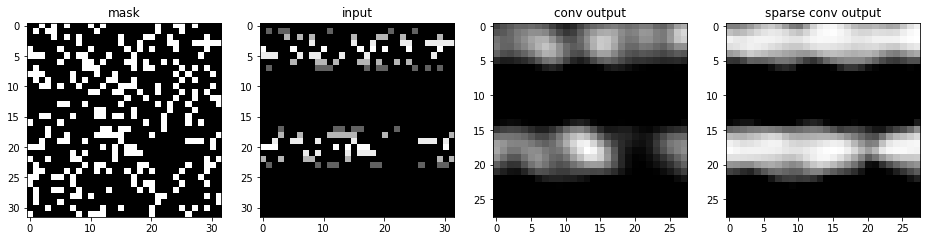

(1.001, 887.68414, 2.7064362)

In [4]:
input_sparsity = 0.75
binary = False

input_masks = np.asarray([np.random.binomial(1, 1-input_sparsity, size=mask_shape)])
input_images = np.asarray([np.random.random(input_shape)]) # random
input_images = np.repeat(np.repeat(np.sin(np.arange(32)/32*4*np.pi)[:,None], 32, axis=-1)[None,:,:,None], 3, axis=-1) # sin
#input_images = np.repeat(np.repeat(np.repeat([[0.,1.],[1.,0.]], 16, axis=0), 16, axis=1)[None,:,:,None], 3, axis=-1) # blocks
input_images += 0.001
#input_images = np.repeat(input_masks, 3, axis=-1) # mask
input_images *= np.repeat(input_masks, input_images.shape[-1], axis=-1)
input_images = np.asarray(input_images, dtype='float32')

inputs = x = Input(shape=input_shape)
x = Conv2D(1, 3, padding='same', bias_initializer='zeros', kernel_initializer='ones')(x)
x = Conv2D(1, 3, padding='valid', bias_initializer='zeros', kernel_initializer='ones')(x)
x = Conv2D(1, 3, padding='valid', bias_initializer='zeros', kernel_initializer='ones')(x)
model = Model(inputs, x)

output_features_conv = Model(model.input, model.layers[-1].output)(input_images)
output_features_conv = output_features_conv.numpy()

inputs = x = Input(shape=input_shape)
x = SparseConv2D(1, 3, padding='same', bias_initializer='zeros', kernel_initializer='ones', binary=binary)(x)
x = SparseConv2D(1, 3, padding='valid', bias_initializer='zeros', kernel_initializer='ones', binary=binary)(x)
x = SparseConv2D(1, 3, padding='valid', bias_initializer='zeros', kernel_initializer='ones', binary=binary)(x)
model = Model(inputs, x)

output_features_sparseconv, output_masks = Model(model.input, model.layers[-1].output)(input_images)
output_features_sparseconv = output_features_sparseconv.numpy()

plt.figure(figsize=[16,4])
opts = {'cmap': 'gray', 'vmin': 0, 'vmax': 1}
plt.subplot(141); plt.title('mask')
plt.imshow(input_masks[0,:,:,0], **opts)
plt.subplot(142); plt.title('input')
v = np.asarray(np.sum(input_images[0], axis=-1), dtype='float32')
plt.imshow(v/np.max(v), **opts)
plt.subplot(143); plt.title('conv output')
v = np.asarray(np.sum(output_features_conv[0], axis=-1), dtype='float32')
plt.imshow(v/np.max(v), **opts)
plt.subplot(144); plt.title('sparse conv output')
v = np.asarray(np.sum(output_features_sparseconv[0], axis=-1), dtype='float32')
plt.imshow(v/np.max(v), **opts)
plt.show()

np.max(input_images), np.max(output_features_conv), np.max(output_features_sparseconv)

0.24883997 0.007193968


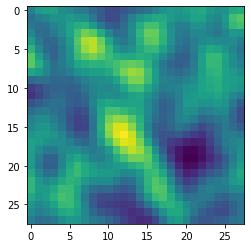

In [5]:
om = output_masks.numpy()
print(np.mean(om), np.var(om))

plt.figure(figsize=[4,4])
plt.imshow(om[0,:,:,0])
plt.show()